# Compute the significance threshold of PDs fom shuffled spike trains
* Use distributed computation


In [1]:
using Pkg
Pkg.activate("../../env/.")
Pkg.instantiate()

  Activating project at `~/analogous_neural/env`


In [2]:
using Distributed
# print number of cores available
print(length(Sys.cpu_info()))

# add cores that I want to use
pids = addprocs(60);

println("number of procs used: ", nprocs())

64number of procs used: 61


In [3]:
@everywhere include("../../src/analogous_bars.jl")
@everywhere using .analogous_bars

WebIO._IJuliaInit()

[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a]


In [4]:
@everywhere include("../../src/Eirene_var.jl")
@everywhere using .Eirene_var
@everywhere using Random
@everywhere using Distances
@everywhere using JLD2
@everywhere using PyCall
@everywhere using FileIO
@everywhere using Statistics
@everywhere using DelimitedFiles
@everywhere using Measures
@everywhere using Plots

In [5]:
@everywhere function shuffle_1d_raster(raster_1d)
        n_neurons, n_bins = size(raster_1d)
        raster_1d_shuffled = zeros((n_neurons, n_bins))
        for cell in 1:n_neurons
            original_1d_raster = raster_1d[cell, :]
            shuffled_1d_raster = original_1d_raster[shuffle(1:end), :]
            raster_1d_shuffled[cell,:] = shuffled_1d_raster
        end
    
        return raster_1d_shuffled
    
    end


@everywhere function compute_shuffled_persistence(V1_aggregate_small, AL_aggregate_small, output_dir, i)
    py"""
import numpy as np
from itertools import combinations
def limited_xcorr_neuron_spiketrain(raster1, neuron1, raster2, neuron2, limit_len):
    # compute limited xcorr score among two neurons
    # note: the two neurons can be in the same region or be in different regions

    # raster_1: V1 raster or AL raster
    # neuron_1: index of V1 neuron
    # raster2: V1 raster or AL raster
    # neuron2: index of AL neuron
    # return a similarity score between two neurons

    n_neurons_1, n_bins_1 = raster1.shape
    n_neurons_2, n_bins_2 = raster2.shape

    n_bins = n_bins_1
    if n_bins_1 != n_bins_2:
        print("Error. Number of bins in two rasters do not match")

    spikes1 = raster1[neuron1,:]
    spikes2 = raster2[neuron2,:]

    x_corr = np.correlate(spikes1, spikes2, 'full')

    # normalize
    norm_factor = np.sqrt(np.dot(spikes1, spikes1) * np.dot(spikes2, spikes2))

    corr_norm = [x / norm_factor for x in x_corr]

    score = sum(corr_norm[n_bins - limit_len: n_bins + limit_len + 1])
    return score

def limited_xcorr_aggregate_raster(raster, limit_len, scale_factor = None):
    # compute limited xcorr similarity and distance for neurons in one region (V1 or AL)
    # --- output ---
    # sim_score : array
    # distance : array
    # --------------
    n_neurons, n_bins = raster.shape
    xcorr_array = np.zeros((n_neurons, n_neurons))

    for (i, j) in combinations(range(n_neurons), 2):
        score = limited_xcorr_neuron_spiketrain(raster, i, raster, j, limit_len)

        xcorr_array[i, j] = score
        xcorr_array[j, i] = score

    if scale_factor == None:
        scale_factor = np.ceil(np.max(xcorr_array))

    xcorr_array_scaled = xcorr_array / scale_factor
    distance = 1 - xcorr_array_scaled
    np.fill_diagonal(distance, 0)

    return xcorr_array, distance
"""

    # shuffle the rasters
    V1_aggregate_shuffled = shuffle_1d_raster(V1_aggregate_small);
    AL_aggregate_shuffled = shuffle_1d_raster(AL_aggregate_small);

    # compute distances from the shuffled raster
    _, V1_shuffled_distance = py"limited_xcorr_aggregate_raster"(V1_aggregate_shuffled, 50, scale_factor = 33)
    _, AL_shuffled_distance = py"limited_xcorr_aggregate_raster"(AL_aggregate_shuffled, 50, scale_factor = 33);

    # compute barcode
    C_V1_shuffled = Eirene_var.eirene(V1_shuffled_distance)
    C_AL_shuffled = Eirene_var.eirene(AL_shuffled_distance)

    barcode_V1_shuffled = Eirene_var.barcode(C_V1_shuffled, dim = 1)
    barcode_AL_shuffled = Eirene_var.barcode(C_AL_shuffled, dim = 1)

    # save
    save(output_dir * string(i) * ".jld2",  "V1_shuffled_barcode", barcode_V1_shuffled,
                                            "AL_shuffled_barcode", barcode_AL_shuffled)

    
end


Load experimentla data

In [6]:
# load pkl data
py"""
import pickle
 
def load_pickle(fpath):
    with open(fpath, "rb") as f:
        data = pickle.load(f)
    return data
"""

load_pickle = py"load_pickle"

PyObject <function load_pickle at 0x7f4d863aff60>

In [7]:
# load raster
AL_raster = load_pickle("data/AL_st_raster.pkl")["stimulus_1"]
V1_raster = load_pickle("data/V1_st_raster.pkl")["stimulus_1"];

# load indices (Python indices)
V1_idx = readdlm("data/V1_neurons_idx.txt", '\t', Int, '\n')
AL_idx = readdlm("data/AL_neurons_idx.txt", '\t', Int, '\n');

V1_idx_python = vcat(V1_idx...)
AL_idx_python = vcat(AL_idx...);
V1_idx_julia = [i+1 for i in V1_idx_python]
AL_idx_julia = [i+1 for i in AL_idx_python]

V1_raster_small = V1_raster[V1_idx_julia,:,:]
AL_raster_small = AL_raster[AL_idx_julia,:,:];

# spike trains (aggregate raster)
V1_aggregate_small = sum(V1_raster_small, dims = 3)[:,:,1];
AL_aggregate_small = sum(AL_raster_small, dims = 3)[:,:,1];

In [16]:
V1_aggregate_shuffled = shuffle_1d_raster(V1_aggregate_small);

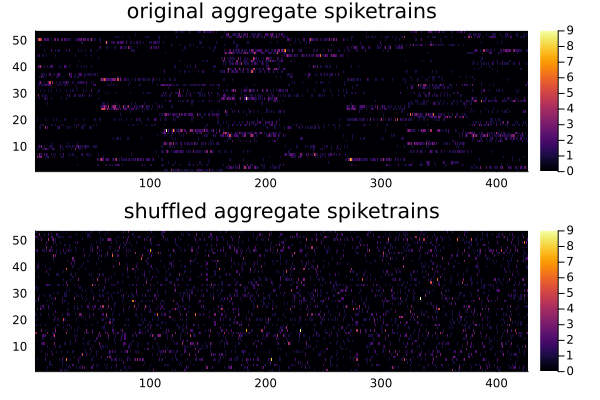

In [17]:
p1 = heatmap(V1_aggregate_small, title = "original aggregate spiketrains")
p2 = heatmap(V1_aggregate_shuffled, title = "shuffled aggregate spiketrains")
plot(p1, p2, layout = (2,1))

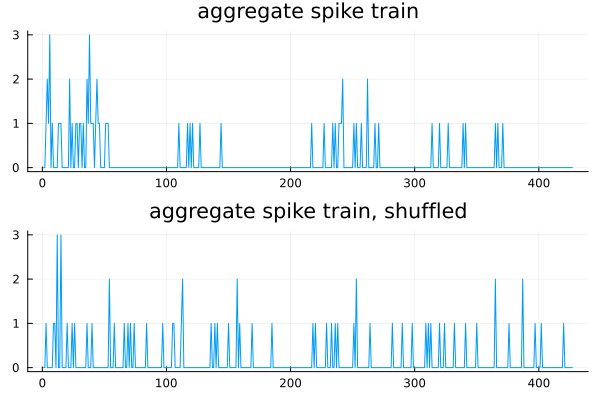

In [10]:
neuron = 10
p1 = plot(V1_aggregate_small[neuron,:], label = "", title = "aggregate spike train")
p2 = plot(V1_aggregate_shuffled[neuron,:], label = "", title = "aggregate spike train, shuffled")
plot(p1, p2, layout = (2,1))


Compute PD from randomly shuffled aggregate spike trains

In [16]:
output_dir = "PD_significance_experiments/shuffled_PD/shuffled_PD"
@distributed for i=1001:10000
    compute_shuffled_persistence(V1_aggregate_small, AL_aggregate_small, output_dir, i)
end

Task (runnable) @0x00007f7aa023b210

Get empirical distribution 

In [4]:
V1_shuffled_persistence = []
AL_shuffled_persistence = []
output_dir = "PD_significance_experiments/shuffled_PD/shuffled_PD"
for i = 1:10000
    # open julia files
    V1_shuffled = FileIO.load(output_dir * string(i) * ".jld2")["V1_shuffled_barcode"]
    AL_shuffled = FileIO.load(output_dir * string(i) * ".jld2")["AL_shuffled_barcode"]
    
    V1_shuffled_persistence = vcat(V1_shuffled_persistence, V1_shuffled[:,2] - V1_shuffled[:,1])
    AL_shuffled_persistence = vcat(AL_shuffled_persistence, AL_shuffled[:,2] - AL_shuffled[:,1])
end

In [6]:
AL_cutoff = maximum(AL_shuffled_persistence)
V1_cutoff = maximum(V1_shuffled_persistence);

println("V1 cutoff: ", V1_cutoff)
println("AL cutoff: ", AL_cutoff)

V1 cutoff: 0.026051040622121713
AL cutoff: 0.011409209171149182


Plot the PD significance

In [27]:
include("../../src/analogous_bars.jl")
using .analogous_bars

In [23]:
# load dissimilarity
total_D = readdlm("data/total_dissimilarity.csv")

# get number of neurons in AL
AL_txt = open("data/AL_neurons_idx.txt", "r")
AL_linebyline = readlines(AL_txt)
close(AL_txt)
n_AL = size(AL_linebyline, 1)

# get number of neurons in V1
V1_txt = open("data/V1_neurons_idx.txt", "r")
V1_linebyline = readlines(V1_txt)
close(V1_txt)
n_V1 = size(V1_linebyline, 1)

# Define submatrices 
D_V1 = total_D[1:n_V1, 1:n_V1]
D_AL = total_D[n_V1+1:end, n_V1+1:end]
D_V1_AL = total_D[1:n_V1, n_V1+1:end]
    # rows (landmarks): V1
    # columns (witness) : AL
D_AL_V1 = total_D[n_V1+1:end, 1:n_V1];
    # rows (landmarks): AL
    # columns (witness) : V1

In [28]:
C_V1 = eirene(D_V1, record = "all", maxdim = 1)
C_AL = eirene(D_AL, record = "all", maxdim = 1)

barcode_V1 = barcode(C_V1, dim = 1)
barcode_AL = barcode(C_AL, dim = 1);

In [43]:
p1 = plot_PD(barcode_V1, title = "PD(V1)", titlefontsize = 15, cutoff = V1_cutoff, markersize = 8, pd_min = 0.53, pd_max = 0.65 )
p2 = plot_PD(barcode_AL, title = "PD(AL)", titlefontsize = 15, cutoff = AL_cutoff, markersize = 8, pd_min = 0.35, pd_max = 0.53)
p = plot(p1, p2, layout = grid(1,2), size = (600, 300))
#savefig("PD_significance_experiments/PD_significance_shuffled_spiketrains.pdf")

"/home/hyoon/analogous_neural/analysis/experimental_visual/PD_significance_shuffled_spiketrains.pdf"

# Witness PD significance from shuffled spike trains

In [34]:
py"""
import numpy as np
from itertools import combinations
from scipy.signal import correlate


def pair_similarity(raster, neuron1, neuron2, limit_len):
    #compute similarity between two neurons in a raster.
    n_bins = raster.shape[1]
    
    spikes1 = raster[neuron1,:]
    spikes2 = raster[neuron2,:]
    norm_factor = np.sqrt(np.dot(spikes1, spikes1) * np.dot(spikes2, spikes2))
    correlation = correlate(spikes1, spikes2, mode = 'same')
    score =sum(correlation[n_bins//2-limit_len:n_bins//2+limit_len])/norm_factor
    return score

def compute_similarity(raster, limit_len):
    # compute similarity among all neurons in a raster.
    similarity = []
    n_neurons = raster.shape[0]
    for (i,j) in combinations(range(n_neurons),2):
        score = pair_similarity(raster, i, j, limit_len)
        similarity.append(score)
    
    return similarity

def cross_pair_similarity(raster1, neuron1, raster2, neuron2, limit_len):
    # compute similarity between neuron1 from raster1 and neuron2 from raster2
    
    if raster1.shape[1] != raster2.shape[1]:
        raise AssertionError('Rasters must have equal number of timebins')
    
    n_bins = raster1.shape[1]
    spikes1 = raster1[neuron1,:]
    spikes2 = raster2[neuron2,:]
    norm_factor = np.sqrt(np.dot(spikes1, spikes1) * np.dot(spikes2, spikes2))
    correlation = correlate(spikes1, spikes2, mode = 'same')
    score =sum(correlation[n_bins//2-limit_len:n_bins//2+limit_len])/norm_factor
    
    return score


def compute_cross_dissimilarity(raster1, raster2, limit_len, scale_factor = None):
    # compute the cross-system similarity and dissimilarity matrix between two rasters
    
    # check if the two rasters have the same number of time bins 
    if raster1.shape[1] != raster2.shape[1]:
        raise AssertionError('Rasters must have equal number of timebins')
    
    n_neurons1 = raster1.shape[0]
    n_neurons2 = raster2.shape[0]
    
    # compute cross-correlogram among neurons in raster1 and raster2
    xcorr = np.zeros((n_neurons1, n_neurons2))
    for neuron1 in range(n_neurons1):
        for neuron2 in range(n_neurons2):
            score = cross_pair_similarity(raster1, neuron1, raster2, neuron2, limit_len)
            xcorr[neuron1, neuron2] = score

               
    # scale the xcorr matrix
    if scale_factor == None:
        scale_factor = np.ceil(np.max(xcorr))

    xcorr_scaled = xcorr/np.ceil(scale_factor)
    distance = 1-xcorr_scaled
    np.fill_diagonal(distance, 0)   
    
    return xcorr, distance
"""

In [35]:
# find the appropriate scale factor from the data
compute_cross_dis = py"compute_cross_dissimilarity"

PyObject <function compute_cross_dissimilarity at 0x7f9ccb9cfce0>

In [37]:
xcorr, distance = compute_cross_dis(V1_aggregate_small, AL_aggregate_small, 50)
print("max scorr: ", maximum(xcorr))

max scorr: 32.3276454986307

In [8]:
@everywhere function shuffle_1d_raster(raster_1d)
        n_neurons, n_bins = size(raster_1d)
        raster_1d_shuffled = zeros((n_neurons, n_bins))
        for cell in 1:n_neurons
            original_1d_raster = raster_1d[cell, :]
            shuffled_1d_raster = original_1d_raster[shuffle(1:end), :]
            raster_1d_shuffled[cell,:] = shuffled_1d_raster
        end
    
        return raster_1d_shuffled   
    end


@everywhere function compute_shuffled_witness_persistence(V1_aggregate_small, AL_aggregate_small, output_dir, i)
    py"""
import numpy as np
from itertools import combinations
from scipy.signal import correlate

def pair_similarity(raster, neuron1, neuron2, limit_len):
    #compute similarity between two neurons in a raster.
    n_bins = raster.shape[1]
    
    spikes1 = raster[neuron1,:]
    spikes2 = raster[neuron2,:]
    norm_factor = np.sqrt(np.dot(spikes1, spikes1) * np.dot(spikes2, spikes2))
    correlation = correlate(spikes1, spikes2, mode = 'same')
    score =sum(correlation[n_bins//2-limit_len:n_bins//2+limit_len])/norm_factor
    return score

def compute_similarity(raster, limit_len):
    # compute similarity among all neurons in a raster.
    similarity = []
    n_neurons = raster.shape[0]
    for (i,j) in combinations(range(n_neurons),2):
        score = pair_similarity(raster, i, j, limit_len)
        similarity.append(score)
    
    return similarity

def cross_pair_similarity(raster1, neuron1, raster2, neuron2, limit_len):
    # compute similarity between neuron1 from raster1 and neuron2 from raster2
    
    if raster1.shape[1] != raster2.shape[1]:
        raise AssertionError('Rasters must have equal number of timebins')
    
    n_bins = raster1.shape[1]
    spikes1 = raster1[neuron1,:]
    spikes2 = raster2[neuron2,:]
    norm_factor = np.sqrt(np.dot(spikes1, spikes1) * np.dot(spikes2, spikes2))
    correlation = correlate(spikes1, spikes2, mode = 'same')
    score =sum(correlation[n_bins//2-limit_len:n_bins//2+limit_len])/norm_factor
    
    return score

def compute_cross_dissimilarity(raster1, raster2, limit_len, scale_factor = None):
    # compute the cross-system similarity and dissimilarity matrix between two rasters
    
    # check if the two rasters have the same number of time bins 
    if raster1.shape[1] != raster2.shape[1]:
        raise AssertionError('Rasters must have equal number of timebins')
    
    n_neurons1 = raster1.shape[0]
    n_neurons2 = raster2.shape[0]
    
    # compute cross-correlogram among neurons in raster1 and raster2
    xcorr = np.zeros((n_neurons1, n_neurons2))
    for neuron1 in range(n_neurons1):
        for neuron2 in range(n_neurons2):
            score = cross_pair_similarity(raster1, neuron1, raster2, neuron2, limit_len)
            xcorr[neuron1, neuron2] = score

               
    # scale the xcorr matrix
    if scale_factor == None:
        scale_factor = np.ceil(np.max(xcorr))

    xcorr_scaled = xcorr/scale_factor
    distance = 1-xcorr_scaled
    np.fill_diagonal(distance, 0)   
    
    return xcorr, distance
"""

    # shuffle the rasters
    V1_aggregate_shuffled = shuffle_1d_raster(V1_aggregate_small);
    AL_aggregate_shuffled = shuffle_1d_raster(AL_aggregate_small);

    # compute cross-distance
    _, x_distance = py"compute_cross_dissimilarity"(V1_aggregate_shuffled, AL_aggregate_shuffled, 50, scale_factor = 33)

    # compute barcode
    C_W = compute_Witness_persistence(x_distance)
    barcode_W = barcode(C_W["eirene_output"], dim = 1);

    # save
    save(output_dir * string(i) * ".jld2",  "shuffled_W_barcode", barcode_W)

    
end


In [13]:
output_dir = "PD_significance_experiments/shuffled_WPD/"
@distributed for i=1001:10000
    compute_shuffled_witness_persistence(V1_aggregate_small, AL_aggregate_small, output_dir, i)
end

Task (runnable) @0x00007f4b033f7b70

In [16]:
W_shuffled_persistence = []

for i = 1:10000
    # open julia files
    W_shuffled = FileIO.load(output_dir * string(i) * ".jld2")["shuffled_W_barcode"]
    W_shuffled_persistence = vcat(W_shuffled_persistence, W_shuffled[:,2] - W_shuffled[:,1])
end

In [20]:
W_shuffled_persistence
W_cutoff = maximum(W_shuffled_persistence)

0.0038936685376764757

In [18]:
# load dissimilarity
total_D = readdlm("data/total_dissimilarity.csv")

# get number of neurons in AL
AL_txt = open("data/AL_neurons_idx.txt", "r")
AL_linebyline = readlines(AL_txt)
close(AL_txt)
n_AL = size(AL_linebyline, 1)

# get number of neurons in V1
V1_txt = open("data/V1_neurons_idx.txt", "r")
V1_linebyline = readlines(V1_txt)
close(V1_txt)
n_V1 = size(V1_linebyline, 1)

# Define submatrices 
D_V1 = total_D[1:n_V1, 1:n_V1]
D_AL = total_D[n_V1+1:end, n_V1+1:end]
D_V1_AL = total_D[1:n_V1, n_V1+1:end]
    # rows (landmarks): V1
    # columns (witness) : AL
D_AL_V1 = total_D[n_V1+1:end, 1:n_V1];
    # rows (landmarks): AL
    # columns (witness) : V1

In [19]:
C_W = compute_Witness_persistence(D_V1_AL)

barcode_W = barcode(C_W["eirene_output"], dim = 1)


2×2 Matrix{Float64}:
 0.402437  0.430375
 0.485231  0.496539

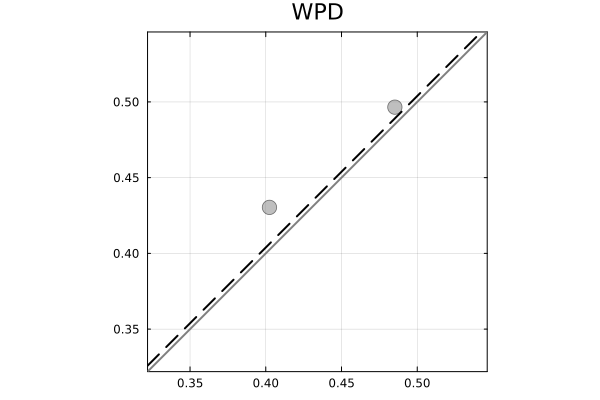

In [23]:
p = plot_PD(barcode_W, title = "WPD", titlefontsize = 15, cutoff = W_cutoff, markersize = 8)
#savefig("PD_significance_experiments/PD_significance_shuffled_spiketrains.pdf")